In [634]:
from sklearn.datasets import make_circles

n_samples = 1000

X, Y = make_circles(n_samples= n_samples, noise=0.03, random_state=42)

In [635]:
len(X), len(Y)

(1000, 1000)

In [636]:
X[:5], Y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [637]:
import pandas as pd
circles_df = pd.DataFrame({"X1": X[:, 0], "X2" : X[:,1], "Y":Y[:]})
circles_df[:10]

,X1,X2,Y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


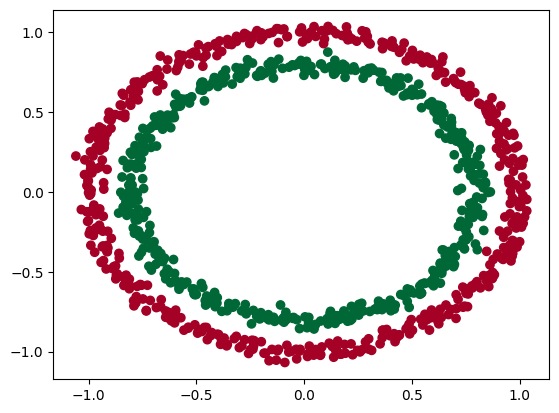

In [638]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0], y = X[:,1], c=Y ,cmap=plt.cm.RdYlGn)

In [639]:
import torch
torch.__version__

'2.2.2+cu121'

In [640]:
# Data to Tensors
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)


In [641]:
X[:3], Y[:3]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733]]),
 tensor([1., 1., 1.]))

In [642]:
type(X), X.shape, X.dim

(torch.Tensor, torch.Size([1000, 2]), <function Tensor.dim>)

In [643]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
type(X_test)

torch.Tensor

In [644]:
len(X_train), len(X_test),len(Y_train), len(Y_test)

(800, 200, 800, 200)

In [645]:
from torch import nn
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


In [646]:
class CircleModel0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=20)
        self.layer2 = nn.Linear(in_features=20, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

model0  = CircleModel0().to("cuda")

In [647]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [648]:
model0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.3691,  0.3716],
                      [ 0.2644, -0.1243],
                      [-0.1872,  0.0756],
                      [-0.1249, -0.2107],
                      [ 0.4520,  0.6077],
                      [-0.0700, -0.1583],
                      [ 0.0103, -0.0422],
                      [ 0.1700,  0.1982],
                      [-0.6422, -0.2609],
                      [ 0.5955,  0.2755],
                      [-0.0352, -0.4263],
                      [-0.4326, -0.6334],
                      [-0.2305,  0.2388],
                      [ 0.4509,  0.3265],
                      [-0.6250, -0.4252],
                      [-0.1116,  0.6840],
                      [ 0.1023, -0.1831],
                      [ 0.2925, -0.2693],
                      [-0.4577,  0.5161],
                      [-0.3215, -0.1418]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.7034,  0.4732,  0.5357,  0.2577, -0.4930, -0.6979, -0.5

In [649]:
X_test = X_test.to("cuda")
untrained_preds = model0(X_test)
print(f"Length of predection: {len(untrained_preds)}, Shape:{untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape:{X_test.shape}")
print(f"\nFirst 10 predections:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{Y_test[:10]}")


Length of predection: 200, Shape:torch.Size([200, 1])
Length of test samples: 200, Shape:torch.Size([200, 2])

First 10 predections:
tensor([[ 0.0157],
        [-0.0631],
        [-0.0298],
        [ 0.0297],
        [-0.4302],
        [-0.4753],
        [-0.3800],
        [-0.4775],
        [-0.0128],
        [-0.0728]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


                                         <---------------------------------------------------------------------------->                                                                 
For regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

                                         <---------------------------------------------------------------------------->                                                                

In [650]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.1)


In [651]:
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct/len(y_preds)) *100
    return acc

<h3>PyTorch training loop</h3>
1. Forward Pass <br>
2. Caluate loss <br>
3. Zero Gradients <br>
4. Preform Backprop on loasss <br>
5. step the optimizer(gradient descent) <br>

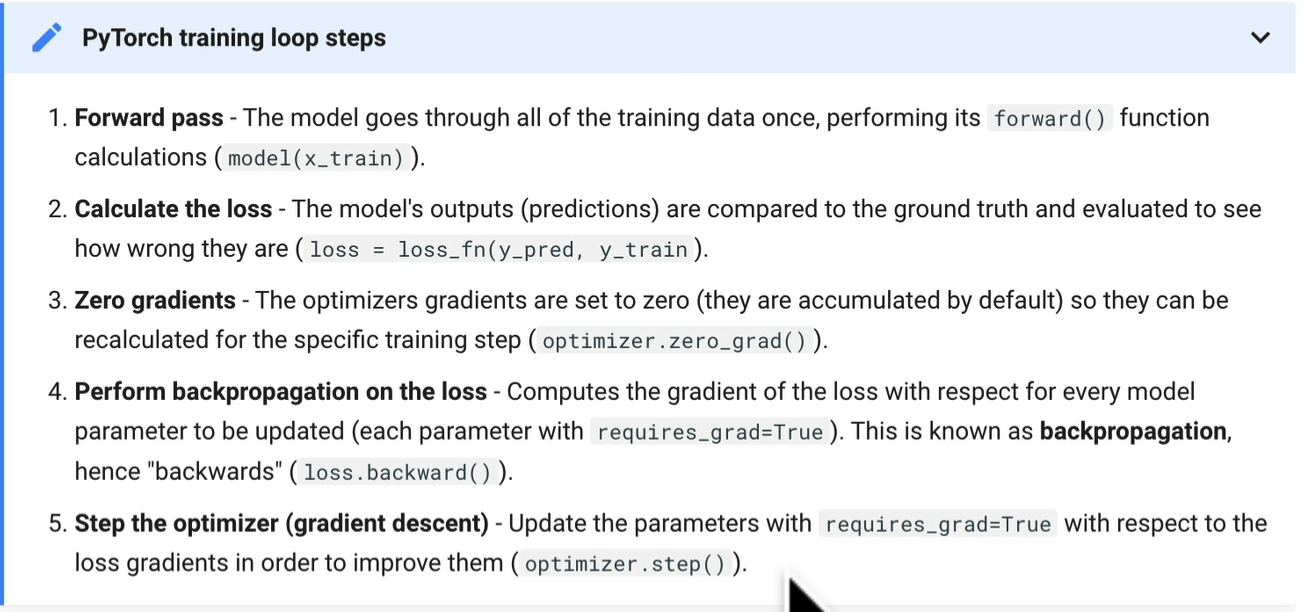

In [652]:
# Checking model with out training for this using model.eval and inference mode to avoid training

model0.eval()
with torch.inference_mode():
    y_logits = model0(X_test)[:5]
y_logits    

tensor([[ 0.0157],
        [-0.0631],
        [-0.0298],
        [ 0.0297],
        [-0.4302]], device='cuda:0')

In [653]:
# using sigmoid with on logits
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5039],
        [0.4842],
        [0.4926],
        [0.5074],
        [0.3941]], device='cuda:0')

In [654]:
# Just to show concept sigmoid activation functuion trains model
torch.round(y_preds_probs), Y_test[:5]

(tensor([[1.],
         [0.],
         [0.],
         [1.],
         [0.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

<h3>Building Training Loop</h3>

In [655]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, Y_train = X_train.to("cuda"), Y_train.to("cuda")
X_test, Y_test = X_test.to("cuda"), Y_test.to("cuda")

for epoch in range(epochs):
    #Trining
    model0.train()

    #Forward pass
    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #Calculate loss
    loss = loss_fn(y_logits, Y_train)

    acc = accuracy_fn(y_true = Y_train, y_preds = y_pred)

    #Optimizer
    optimizer.zero_grad()

    #Loss backward
    loss.backward()

    #optimizer step (gradient descent)
    optimizer.step()

    model0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss
        test_loss = loss_fn(Y_test, test_pred)

        test_acc = accuracy_fn(y_true= Y_test, y_preds= test_pred)

    #print test
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}% ")


Epoch: 0 | Loss: 0.70400, Acc: 46.88% | Test loss: 0.88320 | Test acc: 46.00% 
Epoch: 10 | Loss: 0.69677, Acc: 50.25% | Test loss: 0.78820 | Test acc: 47.50% 
Epoch: 20 | Loss: 0.69526, Acc: 49.12% | Test loss: 0.71820 | Test acc: 52.00% 
Epoch: 30 | Loss: 0.69447, Acc: 49.25% | Test loss: 0.71820 | Test acc: 51.50% 
Epoch: 40 | Loss: 0.69398, Acc: 49.88% | Test loss: 0.71820 | Test acc: 50.00% 
Epoch: 50 | Loss: 0.69367, Acc: 50.88% | Test loss: 0.72820 | Test acc: 49.50% 
Epoch: 60 | Loss: 0.69345, Acc: 50.62% | Test loss: 0.72820 | Test acc: 51.00% 
Epoch: 70 | Loss: 0.69331, Acc: 50.75% | Test loss: 0.73320 | Test acc: 48.50% 
Epoch: 80 | Loss: 0.69321, Acc: 51.12% | Test loss: 0.73820 | Test acc: 47.50% 
Epoch: 90 | Loss: 0.69314, Acc: 50.25% | Test loss: 0.73320 | Test acc: 48.00% 


In [656]:
import HelperFunctions
from HelperFunctions import plot_predictions, plot_decision_boundary


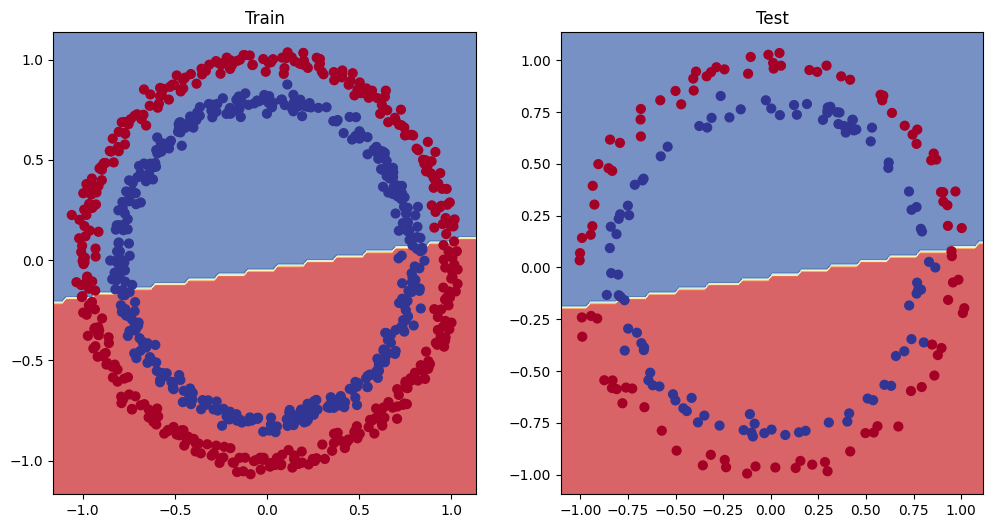

In [657]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, Y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, Y_test)

                                                                                                                                                                                                                                    
<h1 style="text-align: center;"><u><b>Building Non Linear Model</b></u></h1>
                                                                                                                                                                                                                                    

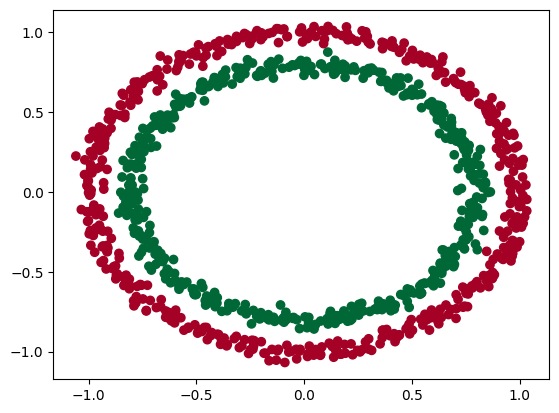

In [658]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, Y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.RdYlGn)

In [659]:
import torch
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

In [660]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [661]:
X_train, Y_train = X_train.to("cuda"), Y_train.to("cuda")
X_test, Y_test = X_test.to("cuda"), Y_test.to("cuda")

In [662]:
from torch import nn

class CircleModelClassV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.Layer1 = nn.Linear(in_features=2, out_features=10)
        self.Layer2 = nn.Linear(in_features=10, out_features=10)
        self.Layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X):
        return self.Layer3(self.relu(self.Layer2(self.Layer1(X))))
        

In [663]:
model_V2 = CircleModelClassV2().to("cuda")
model_V2

CircleModelClassV2(
  (Layer1): Linear(in_features=2, out_features=10, bias=True)
  (Layer2): Linear(in_features=10, out_features=10, bias=True)
  (Layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [664]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_V2.parameters(), lr = 0.1)

In [665]:
# Random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    #Training
    model_V2.train()

    #ForwardPass
    y_logits = model_V2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #Calculate loss
    loss = loss_fn(y_logits, Y_train)
    acc = accuracy_fn(y_true=Y_train, y_preds=y_pred)

    # Optimizer Zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    #Step optimizer
    optimizer.step()

     ### Testing
    model_V2.eval()

    with torch.inference_mode():
        test_logits = model_V2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
    
        test_loss = loss_fn(test_logits, Y_test)
        test_acc = accuracy_fn(y_true=Y_test, y_preds=test_pred)
  
     # Result
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.6983, Acc: 50.00% | Test Loss: 0.6986, Test Acc: 49.00%
Epoch: 100 | Loss: 0.6929, Acc: 50.88% | Test Loss: 0.6941, Test Acc: 47.00%


Epoch: 200 | Loss: 0.6901, Acc: 53.37% | Test Loss: 0.6914, Test Acc: 50.00%
Epoch: 300 | Loss: 0.6876, Acc: 56.62% | Test Loss: 0.6883, Test Acc: 55.00%
Epoch: 400 | Loss: 0.6847, Acc: 60.00% | Test Loss: 0.6847, Test Acc: 61.00%
Epoch: 500 | Loss: 0.6799, Acc: 56.00% | Test Loss: 0.6789, Test Acc: 60.50%
Epoch: 600 | Loss: 0.6728, Acc: 56.00% | Test Loss: 0.6718, Test Acc: 60.50%
Epoch: 700 | Loss: 0.6630, Acc: 64.50% | Test Loss: 0.6645, Test Acc: 65.00%
Epoch: 800 | Loss: 0.6471, Acc: 74.12% | Test Loss: 0.6530, Test Acc: 71.50%
Epoch: 900 | Loss: 0.6218, Acc: 81.62% | Test Loss: 0.6324, Test Acc: 78.00%


In [666]:
model_V2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_V2(X_test))).squeeze()

y_preds[:10], Y_test[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

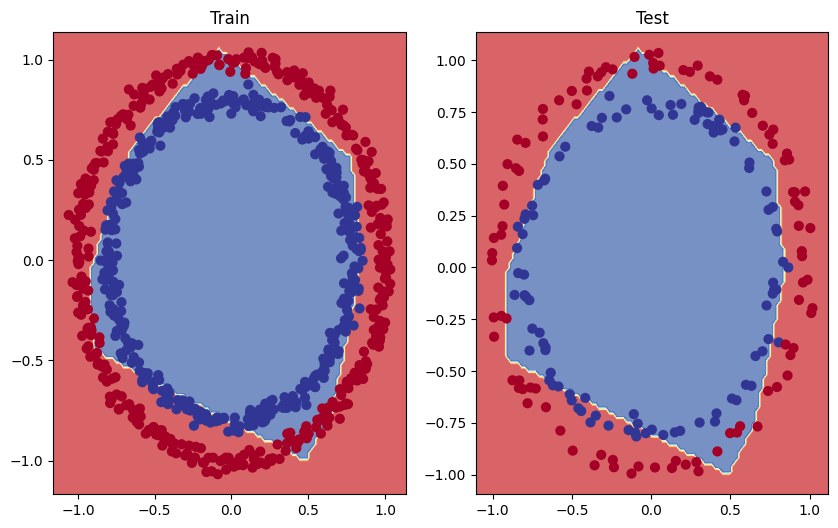

In [667]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_V2, X_train, Y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_V2, X_test, Y_test)






<h1 style="text-align: center;"><b><u>Multi Class Calssification</u></b></h1>




In [668]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES =2
RANDOM_SEED = 42
DEVICE = "cuda"

In [669]:
X_blob, Y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=3, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.LongTensor)

In [670]:
X_train, X_test, Y_train, Y_test = train_test_split(X_blob, Y_blob, train_size=0.8, random_state=RANDOM_SEED)

In [671]:
X_train.shape

torch.Size([800, 2])

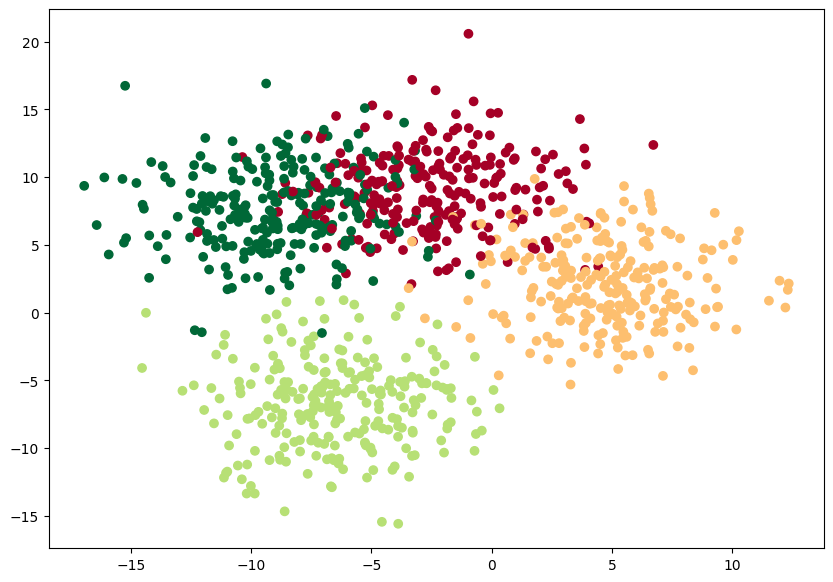

In [672]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=Y_blob, cmap=plt.cm.RdYlGn)

In [673]:
class BlobSplitModel(nn.Module):
    def __init__(self, input_features, output_features, hiddenunits = 10):
        super().__init__()
        self.LayersStack = nn.Sequential(
                nn.Linear(in_features = input_features, out_features = hiddenunits),
                nn.ReLU(),
                nn.Linear(in_features = hiddenunits, out_features = hiddenunits),
                nn.ReLU(),
                nn.Linear(in_features = hiddenunits, out_features = output_features)
        )

    def forward(self, X):
        return self.LayersStack(X)



In [674]:
BlobModel = BlobSplitModel(input_features=2, output_features=4, hiddenunits=10).to(DEVICE)

In [675]:
X_train, Y_train = X_train.to("cuda"), Y_train.to("cuda")
X_test, Y_test = X_test.to("cuda"), Y_test.to("cuda")

In [676]:
loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BlobModel.parameters(), lr=0.1)

In [677]:
epochs = 1000

for epoch in range(epochs):
    BlobModel.train()

    y_logits = BlobModel(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, Y_train)

    acc = accuracy_fn(y_true = Y_train, y_preds = y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    BlobModel.eval()
    with torch.inference_mode():
        test_logits = BlobModel(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
        test_loss = loss_fn(test_logits, Y_test)
        test_acc = accuracy_fn(y_true=Y_test, y_preds=test_pred)
  
     # Result
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.5194, Acc: 10.25% | Test Loss: 1.4809, Test Acc: 24.50%
Epoch: 10 | Loss: 0.3544, Acc: 86.12% | Test Loss: 0.3094, Test Acc: 90.50%
Epoch: 20 | Loss: 0.3006, Acc: 87.62% | Test Loss: 0.2626, Test Acc: 89.00%
Epoch: 30 | Loss: 0.2504, Acc: 90.12% | Test Loss: 0.2060, Test Acc: 89.00%
Epoch: 40 | Loss: 0.2401, Acc: 90.50% | Test Loss: 0.2131, Test Acc: 89.50%
Epoch: 50 | Loss: 0.2380, Acc: 91.12% | Test Loss: 0.2020, Test Acc: 91.00%
Epoch: 60 | Loss: 0.2348, Acc: 91.38% | Test Loss: 0.2163, Test Acc: 91.00%
Epoch: 70 | Loss: 0.2337, Acc: 91.62% | Test Loss: 0.2122, Test Acc: 90.00%
Epoch: 80 | Loss: 0.2316, Acc: 91.00% | Test Loss: 0.2087, Test Acc: 90.50%
Epoch: 90 | Loss: 0.2298, Acc: 90.75% | Test Loss: 0.2119, Test Acc: 91.50%


Epoch: 100 | Loss: 0.2296, Acc: 91.00% | Test Loss: 0.2067, Test Acc: 91.50%
Epoch: 110 | Loss: 0.2295, Acc: 91.62% | Test Loss: 0.2140, Test Acc: 92.50%
Epoch: 120 | Loss: 0.2260, Acc: 91.25% | Test Loss: 0.2158, Test Acc: 92.00%
Epoch: 130 | Loss: 0.2259, Acc: 91.00% | Test Loss: 0.2194, Test Acc: 92.00%
Epoch: 140 | Loss: 0.2291, Acc: 91.25% | Test Loss: 0.1990, Test Acc: 91.00%
Epoch: 150 | Loss: 0.2214, Acc: 91.38% | Test Loss: 0.2115, Test Acc: 91.00%
Epoch: 160 | Loss: 0.2227, Acc: 91.50% | Test Loss: 0.2279, Test Acc: 92.00%
Epoch: 170 | Loss: 0.2252, Acc: 91.50% | Test Loss: 0.2339, Test Acc: 91.00%
Epoch: 180 | Loss: 0.2208, Acc: 91.00% | Test Loss: 0.2185, Test Acc: 91.00%
Epoch: 190 | Loss: 0.2181, Acc: 91.38% | Test Loss: 0.2260, Test Acc: 91.50%
Epoch: 200 | Loss: 0.2156, Acc: 91.62% | Test Loss: 0.2330, Test Acc: 91.00%
Epoch: 210 | Loss: 0.2214, Acc: 90.75% | Test Loss: 0.2222, Test Acc: 92.00%
Epoch: 220 | Loss: 0.2179, Acc: 91.62% | Test Loss: 0.2263, Test Acc: 91.50%

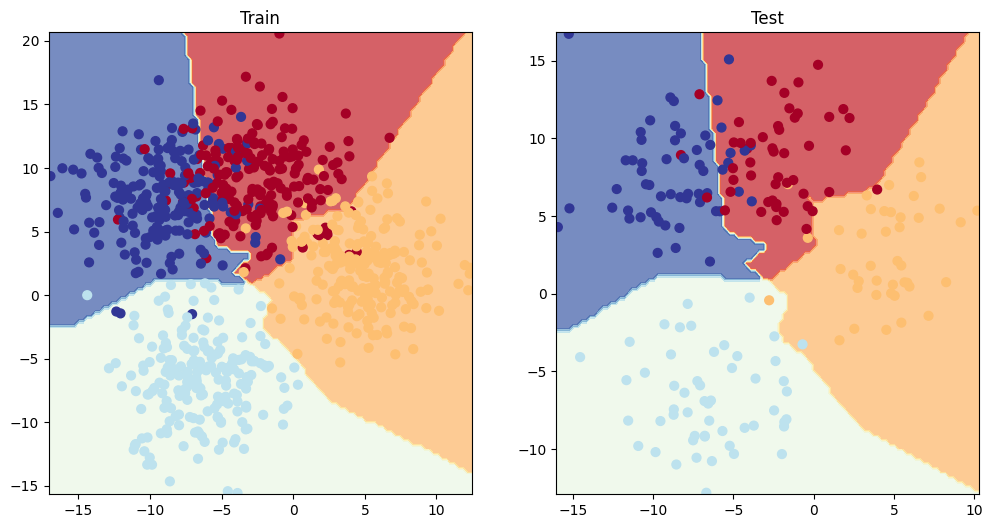

In [678]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(BlobModel, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(BlobModel, X_test, Y_test)